# Enhanced BiLSTM for MOOC Posts – Part 1 Reproduction

This notebook reproduces the **Enhanced Bidirectional LSTM** architecture from the paper using the Stanford MOOC Posts dataset (here, `post_text` + `Urgency_1_7`).

**Instructions:**
1. Upload `Stanford.csv` in the Colab file explorer (left sidebar → Files → Upload).
2. Run all cells from top to bottom.
3. First experiment: model without data augmentation.
4. Second experiment: model with simple EDA-style data augmentation.


In [3]:
!pip install nltk --quiet

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, SpatialDropout1D, Bidirectional, LSTM,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

nltk.download('wordnet')
nltk.download('omw-1.4')

print('TensorFlow version:', tf.__version__)


TensorFlow version: 2.19.0


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [13]:
## Load Stanford.csv (upload it first in Colab /content)
csv_path = '/content/Stanford.csv'  # change if needed

df = pd.read_csv(csv_path, engine="python", on_bad_lines="skip")
print("Columns:", df.columns.tolist())
print("Original shape:", df.shape)


TEXT_COL = 'post_text'
LABEL_COL = 'Urgency_1_7'

# Drop rows with missing text or label
df = df.dropna(subset=[TEXT_COL, LABEL_COL])
df = df[df[TEXT_COL].astype(str).str.strip().astype(bool)]

# Ensure label column is numeric
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors='coerce')
df = df.dropna(subset=[LABEL_COL])
df[LABEL_COL] = df[LABEL_COL].astype(int)

print('After NA cleanup:', df.shape)
df.head()


Columns: ['post_text', 'Urgency Practice', 'Urgency_1_7', 'CourseType']
Original shape: (29604, 4)
After NA cleanup: (29604, 4)


,post_text,Urgency Practice,Urgency_1_7,CourseType
0,Interesting! How often we say those things to ...,NaN,1,Education
1,"What is \Algebra as a Math Game\"" or are you j...",NaN,3,Education
2,I like the idea of my kids principal who says ...,NaN,2,Education
3,"From their responses, it seems the students re...",NaN,2,Education
4,"The boys loved math, because \there is freedom...",NaN,3,Education


In [14]:
## Map 1–7 urgency scores to 3 sentiment-style classes
# 0 = negative/low (1–3), 1 = neutral (4), 2 = positive/high (5–7)

def map_to_3_classes(score: int) -> int:
    if score > 4:
        return 2
    elif score < 4:
        return 0
    else:
        return 1

df['label_3'] = df[LABEL_COL].apply(map_to_3_classes)
print(df['label_3'].value_counts())
df[[TEXT_COL, LABEL_COL, 'label_3']].head()


label_3
0    23186
2     4744
1     1674
Name: count, dtype: int64


,post_text,Urgency_1_7,label_3
0,Interesting! How often we say those things to ...,1,0
1,"What is \Algebra as a Math Game\"" or are you j...",3,0
2,I like the idea of my kids principal who says ...,2,0
3,"From their responses, it seems the students re...",2,0
4,"The boys loved math, because \there is freedom...",3,0


In [15]:
## Text preprocessing: lowercasing, URL/mention removal, non-letters removal, lemmatization

lemmatizer = WordNetLemmatizer()

url_pattern = re.compile(r'https?://\S+|www\.\S+')
mention_pattern = re.compile(r'@\w+')
non_alpha_pattern = re.compile(r'[^a-zA-Z\s]')

def clean_text(text: str) -> str:
    text = str(text).lower()
    text = url_pattern.sub(' ', text)
    text = mention_pattern.sub(' ', text)
    text = non_alpha_pattern.sub(' ', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens]
    return ' '.join(tokens)

df['clean_text'] = df[TEXT_COL].astype(str).apply(clean_text)
df[['clean_text', 'label_3']].head()


,clean_text,label_3
0,interesting how often we say those thing to ot...,0
1,what is algebra a a math game or are you just ...,0
2,i like the idea of my kid principal who say sm...,0
3,from their response it seems the student reall...,0
4,the boy loved math because there is freedom yo...,0


In [16]:
## 60/10/30 split (train/val/test)

X = df['clean_text'].values
y = df['label_3'].values

# First: train+val vs test (70/30)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Then: split train vs val inside train_val (60/10)
val_ratio_within_train = 1.0 / 6.0  # because 60:10 = 6:1
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=val_ratio_within_train,
    stratify=y_train_val,
    random_state=42
)

print('Train size:', len(X_train))
print('Val size   :', len(X_val))
print('Test size  :', len(X_test))


Train size: 17268
Val size   : 3454
Test size  : 8882


In [17]:
# ======================
# Cell 6: Tokenization & Sequence Padding (fixed max length)
# ======================

MAX_NUM_WORDS = 20000   # vocabulary cap
MAX_SEQ_LEN   = 150     # fixed max sequence length (good balance of speed + info)

def prepare_tokenizer_and_sequences(texts_train, texts_val, texts_test, max_len=MAX_SEQ_LEN):
    tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token='<OOV>')
    tokenizer.fit_on_texts(list(texts_train))

    def texts_to_padded(texts, tokenizer, max_len):
        seqs = tokenizer.texts_to_sequences(texts)
        padded = pad_sequences(
            seqs,
            maxlen=max_len,
            padding='post',
            truncating='post'
        )
        return padded

    X_train_seq = texts_to_padded(texts_train, tokenizer, max_len)
    X_val_seq   = texts_to_padded(texts_val,   tokenizer, max_len)
    X_test_seq  = texts_to_padded(texts_test,  tokenizer, max_len)

    return tokenizer, X_train_seq, X_val_seq, X_test_seq, max_len

num_classes = 3
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat   = to_categorical(y_val,   num_classes=num_classes)
y_test_cat  = to_categorical(y_test,  num_classes=num_classes)

print('One-hot label shape (train):', y_train_cat.shape)
print('Max sequence length:', MAX_SEQ_LEN)


One-hot label shape (train): (17268, 3)
Max sequence length: 150


In [9]:
## Download and load GloVe 100d embeddings

!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

GLOVE_PATH = '/content/glove.6B.100d.txt'
EMBEDDING_DIM = 100

embeddings_index = {}
with open(GLOVE_PATH, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found', len(embeddings_index), 'word vectors in GloVe.')


^C
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A
Found 400000 word vectors in GloVe.


In [18]:
# ======================
# Cell 8: Build Embedding Matrix & BiLSTM Model (no recurrent_dropout)
# ======================

def build_embedding_matrix(tokenizer, max_num_words, embedding_dim):
    word_index = tokenizer.word_index
    vocab_size = min(max_num_words, len(word_index) + 1)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        if i >= vocab_size:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix, vocab_size

def build_bilstm_model(vocab_size, embedding_dim, embedding_matrix, max_len):
    model = Sequential()
    model.add(
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            # input_length is optional & deprecated; we can omit it
            trainable=False,
        )
    )
    model.add(SpatialDropout1D(0.2))

    # First BiLSTM layer (128 units) – NO recurrent_dropout (faster CuDNN path)
    model.add(
        Bidirectional(
            LSTM(128, return_sequences=True, dropout=0.3)
        )
    )
    model.add(BatchNormalization())

    # Second BiLSTM layer (64 units) – NO recurrent_dropout
    model.add(
        Bidirectional(
            LSTM(64, dropout=0.3)
        )
    )
    model.add(BatchNormalization())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

def plot_history(history, title_prefix=''):
    plt.figure(figsize=(12,4))
    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [11]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices('GPU'))


GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.6062 - loss: 1.0139 - val_accuracy: 0.7831 - val_loss: 0.6506
Epoch 2/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7746 - loss: 0.6647 - val_accuracy: 0.7831 - val_loss: 0.5444
Epoch 3/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7848 - loss: 0.6060 - val_accuracy: 0.7849 - val_loss: 0.5526
Epoch 4/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.7914 - loss: 0.5665 - val_accuracy: 0.8028 - val_loss: 0.5187
Epoch 5/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7965 - loss: 0.5438 - val_accuracy: 0.8098 - val_loss: 0.5001
Epoch 6/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7930 - loss: 0.5360 - val_accuracy: 0.8141 - val_loss: 0.4926
Epoch 7/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8047 - loss: 0.5184 - val_accuracy: 0.8225 - val_loss: 0.4867
Epoch 8/20
270/270 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.8055 - loss: 0.5066 - 

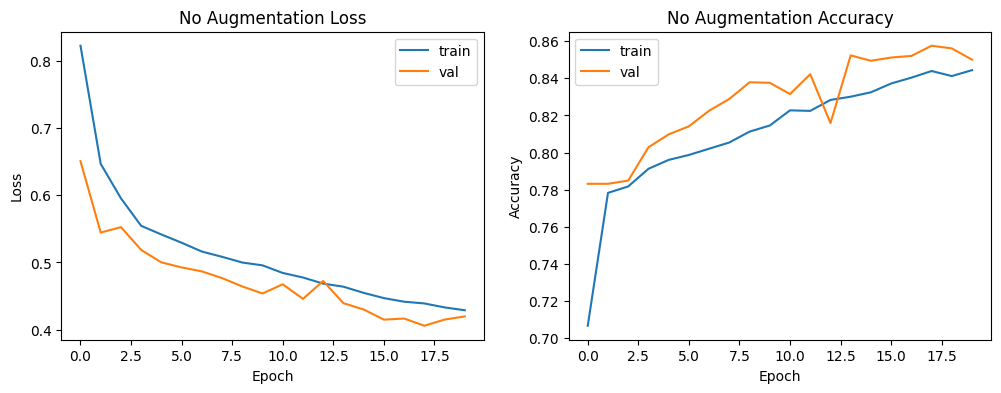

Evaluating on test set (no augmentation model)...
Test accuracy (no aug): 85.07 %
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

Classification Report (No Augmentation):
              precision    recall  f1-score   support

           0     0.8769    0.9644    0.9185      6957
           1     0.0000    0.0000    0.0000       502
           2     0.6881    0.5952    0.6383      1423

    accuracy                         0.8507      8882
   macro avg     0.5216    0.5199    0.5189      8882
weighted avg     0.7971    0.8507    0.8217      8882

Confusion Matrix (No Augmentation):
[[6709    0  248]
 [ 366    0  136]
 [ 576    0  847]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
# =============================
# Cell 9: Experiment 1 – NO augmentation
# =============================

tokenizer_no_aug, X_train_seq, X_val_seq, X_test_seq, max_len = prepare_tokenizer_and_sequences(
    X_train, X_val, X_test
)

embedding_matrix_no_aug, vocab_size_no_aug = build_embedding_matrix(
    tokenizer_no_aug, MAX_NUM_WORDS, EMBEDDING_DIM
)

model_no_aug = build_bilstm_model(
    vocab_size_no_aug, EMBEDDING_DIM, embedding_matrix_no_aug, max_len
)
model_no_aug.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_no_aug = model_no_aug.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_val_seq, y_val_cat),
    epochs=20,              # reduced from 50 (EarlyStopping will still cut it)
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

plot_history(history_no_aug, title_prefix='No Augmentation')

print('Evaluating on test set (no augmentation model)...')
test_loss_no_aug, test_acc_no_aug = model_no_aug.evaluate(X_test_seq, y_test_cat, verbose=0)
print('Test accuracy (no aug):', round(test_acc_no_aug * 100, 2), '%')

y_pred_no_aug = np.argmax(model_no_aug.predict(X_test_seq), axis=1)
print('\nClassification Report (No Augmentation):')
print(classification_report(y_test, y_pred_no_aug, digits=4))

print('Confusion Matrix (No Augmentation):')
print(confusion_matrix(y_test, y_pred_no_aug))


In [21]:
## ==================================
## Simple EDA-style text augmentation
## ==================================

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace('_', ' ').lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(words, n=1):
    words = words.copy()
    candidates = [w for w in words if len(get_synonyms(w)) > 0]
    random.shuffle(candidates)
    num_replaced = 0
    for word in candidates:
        synonyms = get_synonyms(word)
        if synonyms:
            synonym = random.choice(synonyms)
            idxs = [i for i, w in enumerate(words) if w == word]
            if idxs:
                idx = random.choice(idxs)
                words[idx] = synonym
                num_replaced += 1
            if num_replaced >= n:
                break
    return words

def random_deletion(words, p=0.1):
    if len(words) == 1:
        return words
    new_words = []
    for word in words:
        if random.uniform(0,1) > p:
            new_words.append(word)
    if len(new_words) == 0:
        return [random.choice(words)]
    return new_words

def random_swap(words, n=1):
    words = words.copy()
    length = len(words)
    for _ in range(n):
        if length < 2:
            break
        i, j = random.sample(range(length), 2)
        words[i], words[j] = words[j], words[i]
    return words

def augment_sentence(sentence: str) -> str:
    words = sentence.split()
    if len(words) < 3:
        return sentence

    aug_type = random.choice(['sr', 'del', 'swap'])

    if aug_type == 'sr':
        words = synonym_replacement(words, n=1)
    elif aug_type == 'del':
        words = random_deletion(words, p=0.1)
    elif aug_type == 'swap':
        words = random_swap(words, n=1)

    return ' '.join(words)

# Quick test
for i in range(3):
    s = X_train[i]
    print('ORIG:', s[:120])
    print('AUG :', augment_sentence(s)[:120])
    print('---')


ORIG: what make these additional expenditure so heinous is that government spending directly affect the other share of gdp it 
AUG : what make these additional expenditure so heinous is that government spending directly affect the other share of gdp it 
---
ORIG: lady and gentleman i just tried to submit my essay online but wasn t able i am also definitely in time enclosed please f
AUG : lady and gentleman i just tried to submit my essay online but wasn t able i am also definitely in time enclosed please f
---
ORIG: thank you doxie i wa thinking the same thing put in and the product for the losing category come out to negative and the
AUG : thank you doxie i wa thinking the same thing put in and the product for the losing category come out to negative and the
---


In [22]:
## Build augmented training set (1 augmented sample per original)

random.seed(42)

augmented_texts = [augment_sentence(t) for t in X_train]
augmented_labels = y_train.copy()

X_train_aug_all = np.concatenate([X_train, np.array(augmented_texts)])
y_train_aug_all = np.concatenate([y_train, augmented_labels])

print('Original train size:', len(X_train))
print('Augmented train size:', len(X_train_aug_all))


Original train size: 17268
Augmented train size: 34536


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - accuracy: 0.6445 - loss: 0.9488 - val_accuracy: 0.7805 - val_loss: 0.5718
Epoch 2/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.7833 - loss: 0.6074 - val_accuracy: 0.7976 - val_loss: 0.5468
Epoch 3/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7870 - loss: 0.5503 - val_accuracy: 0.8130 - val_loss: 0.4885
Epoch 4/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.7996 - loss: 0.5260 - val_accuracy: 0.8243 - val_loss: 0.4786
Epoch 5/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8088 - loss: 0.5050 - val_accuracy: 0.8353 - val_loss: 0.4583
Epoch 6/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.8235 - loss: 0.4837 - val_accuracy: 0.8379 - val_loss: 0.4539
Epoch 7/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8257 - loss: 0.4788 - val_accuracy: 0.8364 - val_loss: 0.4490
Epoch 8/20
540/540 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.8305 - loss: 0.4591 - 

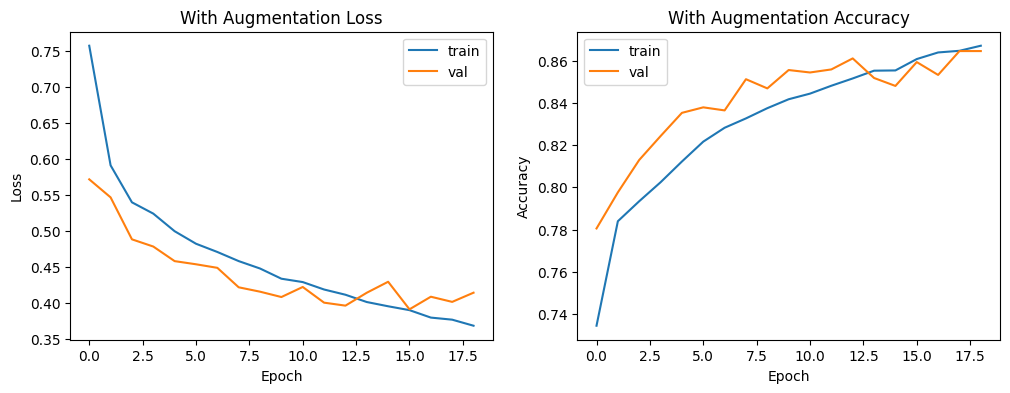

Evaluating on test set (augmentation model)...
Test accuracy (with aug): 85.79 %
278/278 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

Classification Report (With Augmentation):
              precision    recall  f1-score   support

           0     0.9109    0.9406    0.9255      6957
           1     0.0000    0.0000    0.0000       502
           2     0.6337    0.7561    0.6895      1423

    accuracy                         0.8579      8882
   macro avg     0.5149    0.5656    0.5384      8882
weighted avg     0.8150    0.8579    0.8354      8882

Confusion Matrix (With Augmentation):
[[6544    0  413]
 [ 293    0  209]
 [ 347    0 1076]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
# =============================
# Cell 12: Experiment 2 – WITH augmentation
# =============================

tokenizer_aug, X_train_aug_seq, X_val_aug_seq, X_test_aug_seq, max_len_aug = prepare_tokenizer_and_sequences(
    X_train_aug_all, X_val, X_test
)

embedding_matrix_aug, vocab_size_aug = build_embedding_matrix(
    tokenizer_aug, MAX_NUM_WORDS, EMBEDDING_DIM
)

y_train_aug_cat = to_categorical(y_train_aug_all, num_classes=num_classes)

model_aug = build_bilstm_model(
    vocab_size_aug, EMBEDDING_DIM, embedding_matrix_aug, max_len_aug
)
model_aug.summary()

early_stop_aug = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_aug = model_aug.fit(
    X_train_aug_seq, y_train_aug_cat,
    validation_data=(X_val_aug_seq, y_val_cat),
    epochs=20,              # reduced from 50
    batch_size=64,
    callbacks=[early_stop_aug],
    verbose=1
)

plot_history(history_aug, title_prefix='With Augmentation')

print('Evaluating on test set (augmentation model)...')
test_loss_aug, test_acc_aug = model_aug.evaluate(X_test_aug_seq, y_test_cat, verbose=0)
print('Test accuracy (with aug):', round(test_acc_aug * 100, 2), '%')

y_pred_aug = np.argmax(model_aug.predict(X_test_aug_seq), axis=1)
print('\nClassification Report (With Augmentation):')
print(classification_report(y_test, y_pred_aug, digits=4))

print('Confusion Matrix (With Augmentation):')
print(confusion_matrix(y_test, y_pred_aug))


In [24]:
## =============================
## Summary: No Aug vs With Aug
## =============================

print('Test accuracy (no augmentation):   ', round(test_acc_no_aug*100, 2), '%')
print('Test accuracy (with augmentation):', round(test_acc_aug*100, 2), '%')

summary_df = pd.DataFrame({
    'Setting': ['No Augmentation', 'With Augmentation'],
    'Test Accuracy': [test_acc_no_aug, test_acc_aug]
})
summary_df


Test accuracy (no augmentation):    85.07 %
Test accuracy (with augmentation): 85.79 %


,Setting,Test Accuracy
0,No Augmentation,0.850709
1,With Augmentation,0.857915
